In [ ]:
import numpy as np
import pandas as pd
import re

# NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
dataset = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t')


In [ ]:
print(dataset.head())



                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [ ]:
print(dataset.info())
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None
(1000, 2)


In [ ]:
print(dataset.columns)

Index(['Review', 'Liked'], dtype='object')


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

corpus = []

for review in dataset.iloc[:, 0]:
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower().split()
    review = [
        lemmatizer.lemmatize(word)
        for word in review
        if word not in stop_words
    ]
    corpus.append(' '.join(review))


In [ ]:
tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [ ]:
nb = MultinomialNB()

nb_param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    estimator=nb,
    param_grid=nb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

nb_grid.fit(X_train, y_train)
best_nb = nb_grid.best_estimator_

print("Best Naive Bayes params:", nb_grid.best_params_)


Best Naive Bayes params: {'alpha': 0.5}


In [ ]:
lr = LogisticRegression(max_iter=2000)

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

print("Best Logistic Regression params:", lr_grid.best_params_)


Best Logistic Regression params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
svm = LinearSVC()

svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

print("Best SVM params:", svm_grid.best_params_)


Best SVM params: {'C': 0.1}


In [ ]:
def evaluate_model(name, model, X_test, y_test, prob=False):
    y_pred = model.predict(X_test)

    print(f"\n{name}")
    print("-" * 40)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    if prob:
        y_prob = model.predict_proba(X_test)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_prob))


In [ ]:
evaluate_model("Tuned Naive Bayes", best_nb, X_test, y_test, prob=True)
evaluate_model("Tuned Logistic Regression", best_lr, X_test, y_test, prob=True)
evaluate_model("Tuned Linear SVM", best_svm, X_test, y_test)



Tuned Naive Bayes
----------------------------------------
Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.69      0.73       125
           1       0.72      0.79      0.75       125

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250

ROC-AUC: 0.83216

Tuned Logistic Regression
----------------------------------------
Accuracy: 0.744
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       125
           1       0.74      0.76      0.75       125

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250

ROC-AUC: 0.81584

Tuned Linear SVM
----------------------------------------
Accuracy: 0.74
Classification Report:
        

Naive Bayes classifier was selected as the final model based on superior ROC-AUC (0.83) and recall, indicating better class discrimination compared to Logistic Regression and Linear SVM.

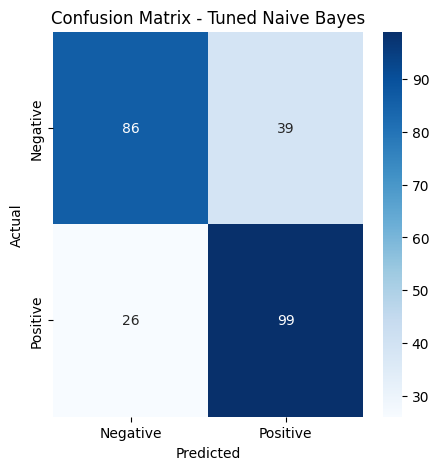

In [ ]:
# Confusion Matrix for Final Model (Naive Bayes)

y_pred_nb = best_nb.predict(X_test)

cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Naive Bayes')
plt.show()


In [ ]:
# Interpretability for Naive Bayes

feature_names = tfidf.get_feature_names_out()

# Log probabilities for each class
log_prob_negative = best_nb.feature_log_prob_[0]
log_prob_positive = best_nb.feature_log_prob_[1]

# Top indicative words
top_positive = np.argsort(log_prob_positive)[-10:]
top_negative = np.argsort(log_prob_negative)[-10:]

print("Top words indicating POSITIVE sentiment:")
print(feature_names[top_positive])

print("\nTop words indicating NEGATIVE sentiment:")
print(feature_names[top_negative])


Top words indicating POSITIVE sentiment:
['also' 'nice' 'friendly' 'amazing' 'delicious' 'service' 'food' 'place'
 'great' 'good']

Top words indicating NEGATIVE sentiment:
['would' 'ever' 'time' 'disappointed' 'like' 'place' 'go' 'food' 'service'
 'back']
